# How does HPL geometry affect the DGEMM sizes?

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)), names=columns, index_col=False)
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    result['geometry'] = result['proc_p'].astype(str) + '×' + result['proc_q'].astype(str)
    info = get_yaml(name, 'info.yaml')
    expfiles = info['expfile']
    dgemm_file = [f for f in expfiles if f.endswith('.yaml')]
    assert len(dgemm_file) == 1
    dgemm_model = get_yaml(name, dgemm_file[0])
    kernels = read_csv(name, 'trace_blas_0.csv', columns=['file', 'lineno', 'function', 'rank', 'start', 'duration', 'm', 'n', 'k'])
    kernels['function'] = kernels['function'].str.strip()
    kernels = kernels[kernels['function'] == 'dgemm']
    kernels['mnk'] = kernels.m * kernels.n * kernels.k
    kernels = kernels[kernels.mnk > 0]
    geom = result['geometry'].unique()
    assert len(geom) == 1
    kernels['geometry'] = geom[0]
    return result, kernels

simulation_dir = 'geometry/16/'
simulation_files = []
dataframes = []
traces = []
for f in os.listdir(simulation_dir):
    path = os.path.join(simulation_dir, f)
    simulation_files.append(path)
    df, trace = read_sim_result(path)
    dataframes.append(df)
    traces.append(trace)

df = pandas.concat(dataframes)
trace = pandas.concat(traces)
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,simulation_time,application_time,usr_time,sys_time,major_page_fault,minor_page_fault,cpu_utilization,platform,filename,geometry
0,250000,128,30,32,1,2,2,1,0,8,...,44.8999,20.5131,39.68,7.39,0,2080354,1.04,dahu.xml,geometry/16/nancy_2020-07-03_2638024.zip,30×32
0,250000,128,480,2,1,2,2,1,0,8,...,401.4760,47.9652,310.48,93.46,0,55622126,1.00,dahu.xml,geometry/16/nancy_2020-07-03_2638023.zip,480×2
0,250000,128,2,480,1,2,2,1,0,8,...,46.3433,21.6884,43.28,5.15,0,436533,1.04,dahu.xml,geometry/16/nancy_2020-07-03_2638025.zip,2×480


In [2]:
trace.head()

,file,lineno,function,rank,start,duration,m,n,k,filename,mnk,geometry
16,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224,dgemm,0,0.000080,0.000029,8446.0,2.0,2.0,geometry/16/nancy_2020-07-03_2638024.zip,33784.0,30×32
36,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224,dgemm,0,0.000191,0.000058,8444.0,4.0,4.0,geometry/16/nancy_2020-07-03_2638024.zip,135104.0,30×32
52,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224,dgemm,0,0.000307,0.000029,8442.0,2.0,2.0,geometry/16/nancy_2020-07-03_2638024.zip,33768.0,30×32
75,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224,dgemm,0,0.000476,0.000134,8440.0,8.0,8.0,geometry/16/nancy_2020-07-03_2638024.zip,540160.0,30×32
95,/tmp/hpl-2.2/src/pfact/HPL_pdrpanrlT.c,224,dgemm,0,0.000685,0.000029,8438.0,2.0,2.0,geometry/16/nancy_2020-07-03_2638024.zip,33752.0,30×32


### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,rfact,pfact,swap,process_per_node,bcast,proc_p,mem_align,block_size,geometry,proc_q,depth,thread_per_process
0,2,1,0,32,2,30,8,128,30×32,32,1,1
0,2,1,0,32,2,480,8,128,480×2,2,1,1
0,2,1,0,32,2,2,8,128,2×480,480,1,1


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the simulation

In [5]:
patches = set()
for row in df.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/pgesv/HPL_pdgesv0.c b/src/pgesv/HPL_pdgesv0.c
index 8bcf71a..ff2a1b9 100644
--- a/src/pgesv/HPL_pdgesv0.c
+++ b/src/pgesv/HPL_pdgesv0.c
@@ -126,6 +126,9 @@ void HPL_pdgesv0
    for( j = 0; j < N; j += nb )
    {
       n = N - j; jb = Mmin( n, nb );
+      if(j/nb >= 5) {
+        return;
+      }
 #ifdef HPL_PROGRESS_REPORT
       /* if this is process 0,0 and not the first panel */
       if ( GRID->myrow == 0 && GRID->mycol == 0 && j > 0 )
diff --git a/src/pgesv/HPL_pdgesvK2.c b/src/pgesv/HPL_pdgesvK2.c
index 3aa7f2b..ed9c90a 100644
--- a/src/pgesv/HPL_pdgesvK2.c
+++ b/src/pgesv/HPL_pdgesvK2.c
@@ -172,6 +172,9 @@ void HPL_pdgesvK2
    for( j = jstart; j < N; j += nb )
    {
       n = N - j; jb = Mmin( n, nb );
+      if((j-jstart)/nb >= 5) {
+        return;
+      }
 #ifdef HPL_PROGRESS_REPORT
       /* if this is process 0,0 and not the first panel */
       if ( GRID->myrow == 0 && mycol == 0 && j > 0 )


diff --git a/testing/ptest/HPL_pdtest.c b/testing/ptest/HPL_pdtest.c
index 33b11ac..dea0d93 100644
--- a/testing/ptest/HPL_pdtest.c
+++ b/testing/ptest/HPL_pdtest.c
@@ -197,7 +197,14 @@ void HPL_pdtest
    HPL_ptimer_boot(); (void) HPL_barrier( GRID->all_comm );
    time( &current_time_start );
    HPL_ptimer( 0 );
+   int n = 12;
+   MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);
+   timestamp_t start = get_timestamp();
+   record_measure(__FILE__, __LINE__, "smpi_marker", start, 0, 0, NULL);
    HPL_pdgesv( GRID, ALGO, &mat );
+   timestamp_t end = get_timestamp();
+   record_measure(__FILE__, __LINE__, "smpi_marker", end, 0, 0, NULL);
+   MPI_Bcast(&n, 1, MPI_INT, 0, MPI_COMM_WORLD);
    HPL_ptimer( 0 );
    time( &current_time_end );
 #ifdef HPL_CALL_VSIPL
    
```

## Comparing HPL performance of the different models

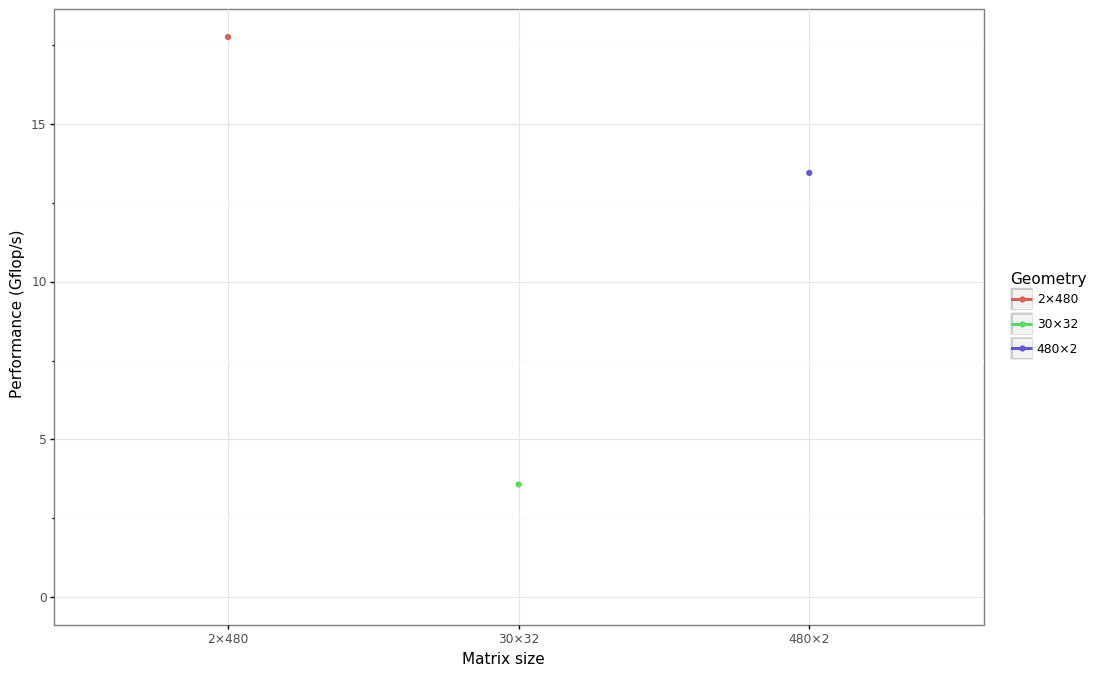

<ggplot: (-9223363257565662923)>

In [6]:
plot = ggplot(df) + aes(x='geometry', y='time', color='geometry') + geom_point() + geom_line()
plot = plot + xlab('Matrix size') + ylab('Performance (Gflop/s)') + labs(color='Geometry') + expand_limits(y=0)
plot = plot + theme_bw()
plot

## Comparing the traces

In [7]:
trace['node'] = trace['rank'] // 32
trace['cpu'] = trace['node']*2 + trace['rank']%2
trace['cpu'].unique()

array([ 0,  6,  7,  1,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21,  2,  3, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41,  4,  5, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

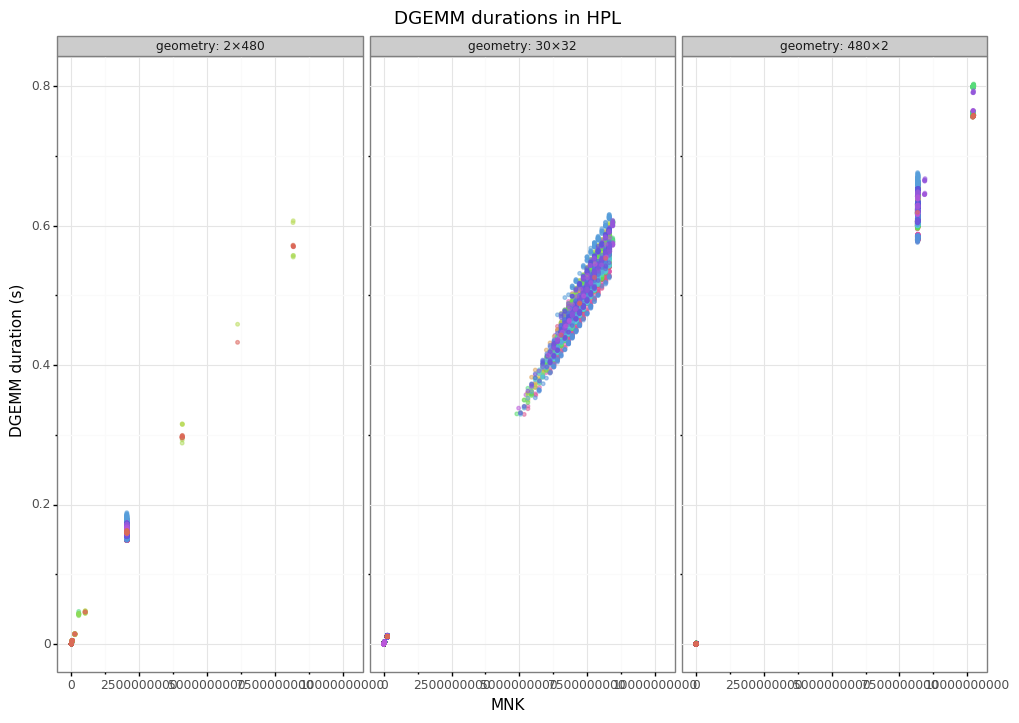

<ggplot: (8779289087040)>


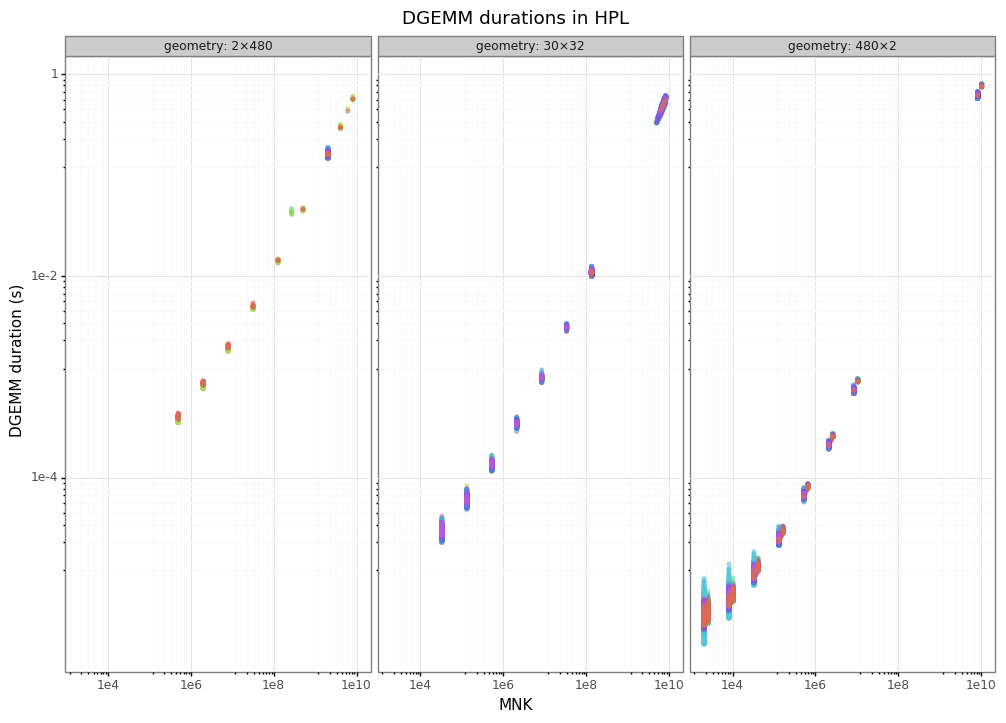

<ggplot: (8779290594908)>


In [8]:
trace['cpu_id'] = trace['node'].astype(str) + ':' + trace['cpu'].astype(str)
plot = ggplot(trace) + aes(x='mnk', y='duration', color='cpu_id') + geom_point(size=1, alpha=0.5)
plot = plot + xlab('MNK') + ylab('DGEMM duration (s)') + facet_wrap('geometry', labeller='label_both')
plot = plot + theme_bw() + ggtitle('DGEMM durations in HPL') + theme(legend_position = 'none')
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

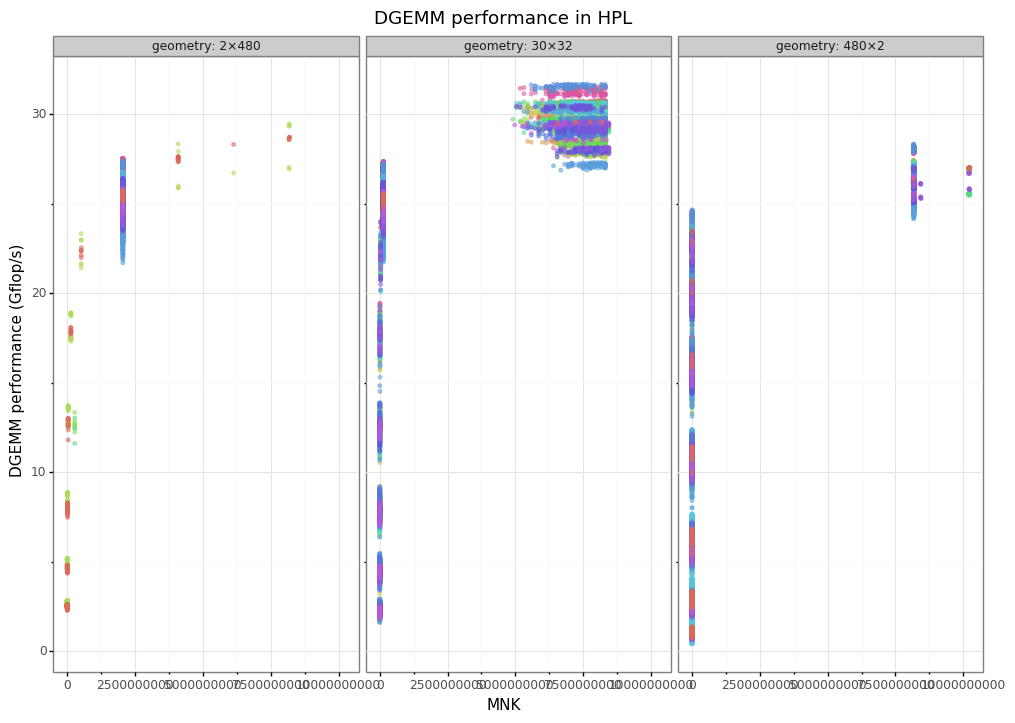

<ggplot: (8779291970354)>


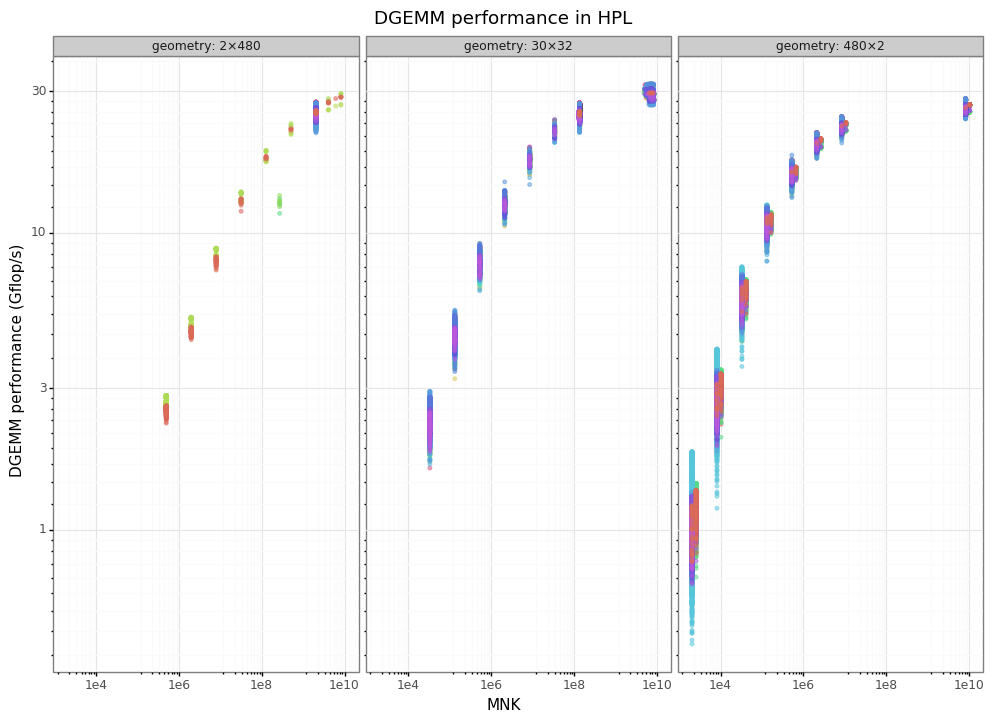

<ggplot: (8779293319586)>


In [9]:
trace['gflops'] = 2*trace['mnk'] / trace['duration'] * 1e-9
plot = ggplot(trace) + aes(x='mnk', y='gflops', color='cpu_id') + geom_point(size=1, alpha=0.5)
plot = plot + xlab('MNK') + ylab('DGEMM performance (Gflop/s)') + facet_wrap('geometry', labeller='label_both')
plot = plot + theme_bw() + ggtitle('DGEMM performance in HPL') + theme(legend_position = 'none')
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

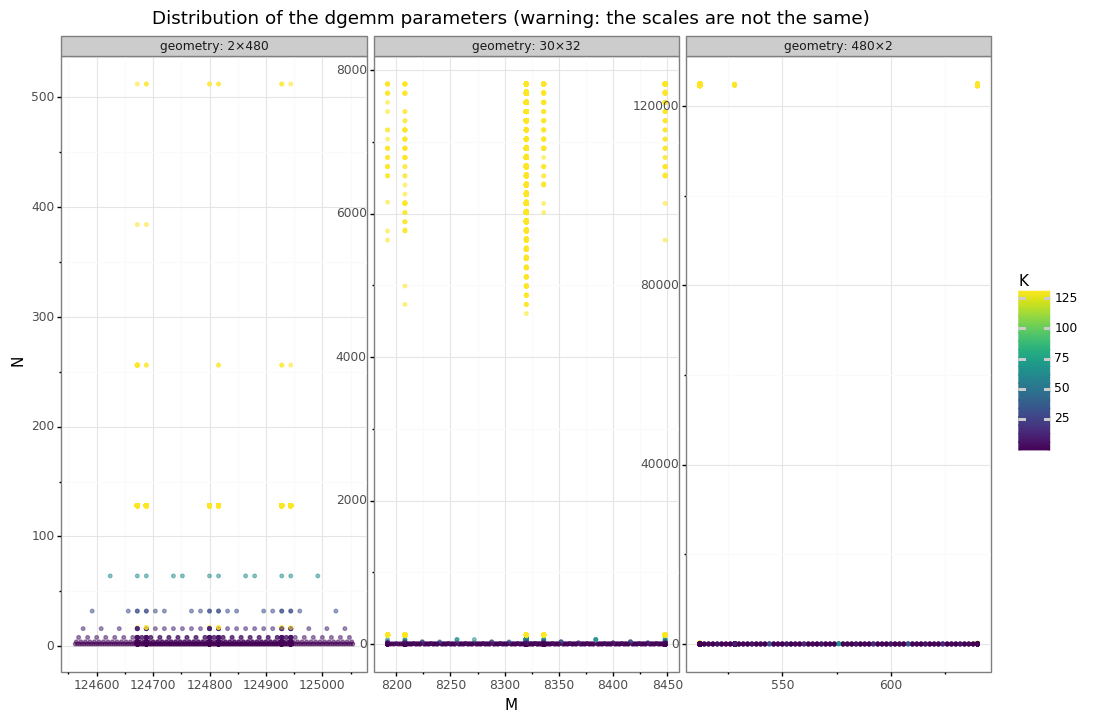

<ggplot: (8779293262996)>

In [10]:
(ggplot(trace)
 + aes(x='m', y='n', color='k')
 + geom_point(size=1, alpha=0.5)
 + facet_wrap('geometry', labeller='label_both', scales='free')
 + theme_bw()
 + labs(x='M', y='N', color='K')
 + ggtitle('Distribution of the dgemm parameters (warning: the scales are not the same)')
)

## Work in-balance

In [11]:
grouped = trace.groupby(['rank', 'node', 'cpu', 'geometry'])[['duration', 'mnk']].sum().reset_index()
grouped['gflops'] = 2*grouped['mnk'] / grouped['duration'] * 1e-9
grouped.head()

,rank,node,cpu,geometry,duration,mnk,gflops
0,0,0,0,2×480,3.342664,4.191079e+10,25.076279
1,0,0,0,30×32,2.882411,4.164365e+10,28.895015
2,0,0,0,480×2,3.106219,4.091576e+10,26.344415
3,1,0,1,2×480,3.442875,4.395709e+10,25.535110
4,1,0,1,30×32,2.884628,4.118839e+10,28.557158


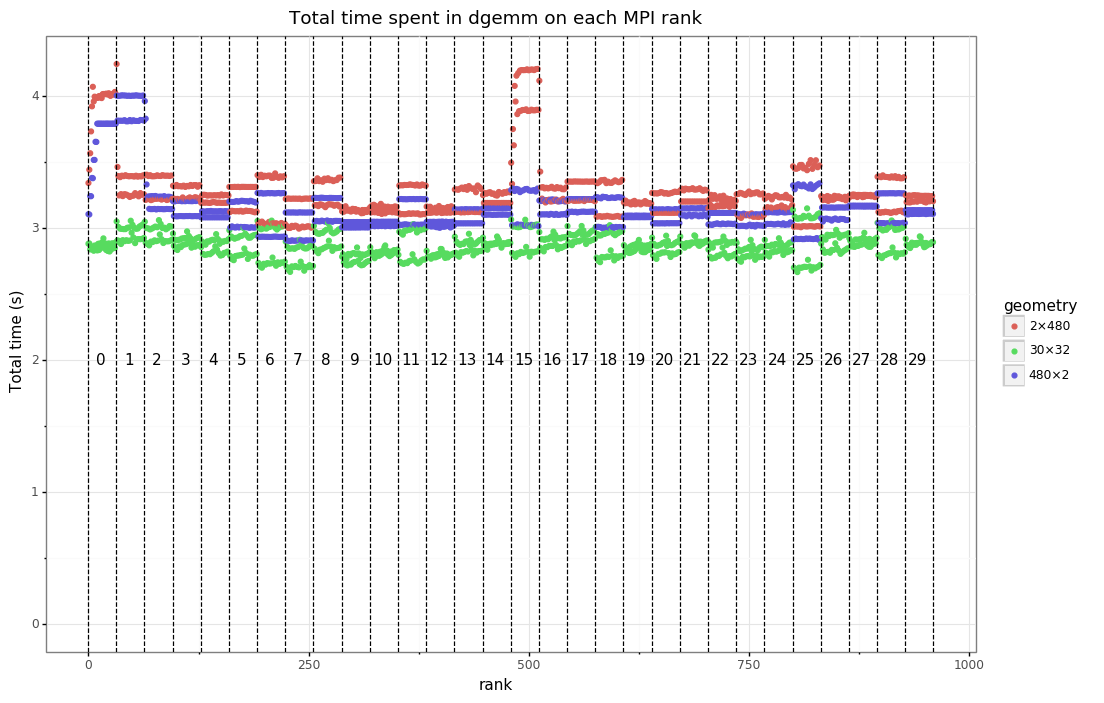

<ggplot: (8779289378340)>

In [12]:
plot = ggplot(grouped) + aes(x='rank', y='duration', color='geometry') + geom_point()
plot = plot + theme_bw() + ggtitle('Total time spent in dgemm on each MPI rank') + ylab('Total time (s)') + expand_limits(y=0)
for i in range(0, 31):
    plot = plot + geom_vline(xintercept=i*32-0.5, linetype='dashed')
for i in range(0, 30):
    plot = plot + annotate('text', label=str(i), x=i*32+14, y=2)
plot

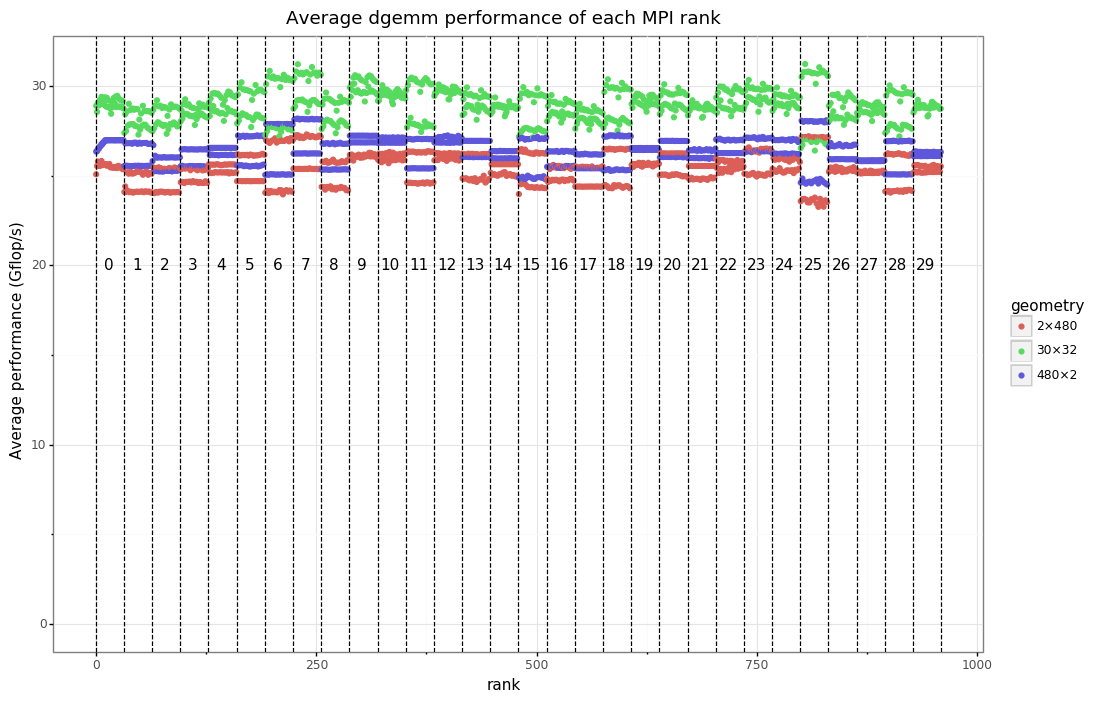

<ggplot: (8779289345316)>

In [13]:
plot = ggplot(grouped) + aes(x='rank', y='gflops', color='geometry') + geom_point() + expand_limits(y=0)
plot = plot + theme_bw() + ggtitle('Average dgemm performance of each MPI rank') + ylab('Average performance (Gflop/s)')
for i in range(0, 31):
    plot = plot + geom_vline(xintercept=i*32-0.5, linetype='dashed')
for i in range(0, 30):
    plot = plot + annotate('text', label=str(i), x=i*32+14, y=20)
plot

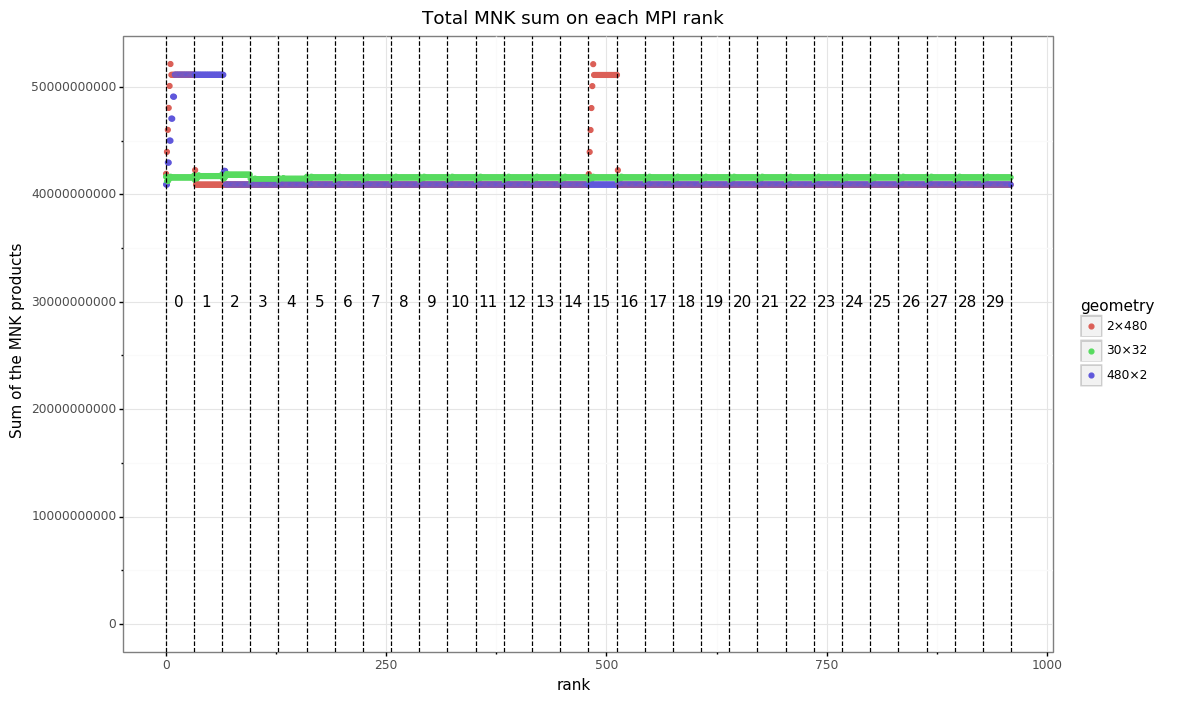

<ggplot: (8779289321890)>

In [14]:
plot = ggplot(grouped) + aes(x='rank', y='mnk', color='geometry') + geom_point()
plot = plot + theme_bw() + ggtitle('Total MNK sum on each MPI rank') + ylab('Sum of the MNK products') + expand_limits(y=0)
for i in range(0, 31):
    plot = plot + geom_vline(xintercept=i*32-0.5, linetype='dashed')
for i in range(0, 30):
    plot = plot + annotate('text', label=str(i), x=i*32+14, y=3e10)
plot